In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%load_ext tensorboard

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [5]:
from PIL import Image
from IPython.display import display

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split

from build_model_classifier import build_model_classifier_1, build_model_classifier_2, build_model_classifier_3
from load_image import load_image
from get_frames import get_frames
from load_models import load_models
from get_labels import get_windows_original, get_windows_encoded, get_labels, get_defect_label
from assemble_image import assemble_image

from get_labels import get_defect_type
from prediction import predict_step, predict_image
from conf_matrix import get_accuracy, get_confusion_matrix, plot_confusion_matrix

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

In [7]:
#gpu check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [32]:
#manual confusion matrix assembly
stride_step = 50
unit_numb = 5

#load data image list
test_size = 0.1
norm_factor=1
dtype = 'uint8'

filename = f'save_data/e_d_test_all_str_50_ts_{test_size}_{dtype}_norm_{norm_factor}.pkl'

#load data
with open(filename, 'rb') as f:
    image_list,frames_data = pickle.load(f)
    
del frames_data

if 1:
    image_list = [
        'Pucker26.png',
        'Twist22.png',
        'Twist23.png',
        'Fold22.png',
        'Pucker13.png',
        'Pucker3.png',
        'Twist10.png',
        'Pucker31.png',
        'Fold21.png',
        'Fold9.png',
    ]

#image list
print('Image list:')
print('\n'.join([f'{i}: {image}' for i, image in enumerate(image_list)]))

window_size = 6
window_size_predicted = 1
overlap = 0
repeat_prediction = 6
stateful = False
lstm_type = 'win'

lstm_pars_dict = {
    'window_size':window_size,
    'window_size_predicted':window_size_predicted,
    'overlap':overlap,
    'repeat_prediction':repeat_prediction,
    'stateful':stateful,
    'lstm_type':lstm_type
}

padding_dict = {
    'ifPadding':True,
    'max_window_size':12,        
}

#load labels
file_name = f'defects_borders.json'
folder = f'save_data/classify_data' 
with open(f'{folder}/{file_name}', 'r') as f:
    borders_dict = json.load(f)

models_dict = load_models(unit_numb, stride_step, lstm_pars_dict, classifier=True, ifProbability=False)

y_pred_array = np.array([])
y_gt_array = np.array([])

if 1:
    for filename in image_list:
        image_data = load_image(filename)
        image_data_frames = get_frames(image_data, stride_step, ifPrint = False)
        window_size_total = window_size + (window_size_predicted-overlap)*repeat_prediction
        windows_data = get_windows_original(image_data_frames, stride_step, window_size_total, padding_dict)
        windows_data_encoded = get_windows_encoded(windows_data, models_dict['model_encoder'])

        #true labels
        defect_type = get_defect_label(filename)
        borders_list = borders_dict[filename]
        image_length = image_data.shape[1]

        labels_gt = get_labels(
            stride_step,
            borders_list, 
            image_length, 
            window_size_total, 
            defect_type
        )

        # Get probabilities
        y_pred_probs = models_dict['model_classifier'].predict(windows_data_encoded, verbose=0)  
        # Convert probabilities to class labels
        y_pred = np.argmax(y_pred_probs, axis=1)

        y_pred_array = np.append(y_pred_array, y_pred)
        y_gt_array = np.append(y_gt_array, labels_gt)


        #break

Image list:
0: Pucker26.png
1: Twist22.png
2: Twist23.png
3: Fold22.png
4: Pucker13.png
5: Pucker3.png
6: Twist10.png
7: Pucker31.png
8: Fold21.png
9: Fold9.png


LS:5. Accuracy 0.9536231884057971
LS:5. Precision: 0.9508614485300986
LS:5. Recall: 0.9594485581470463
LS:5. F1_score: 0.9522189066353901


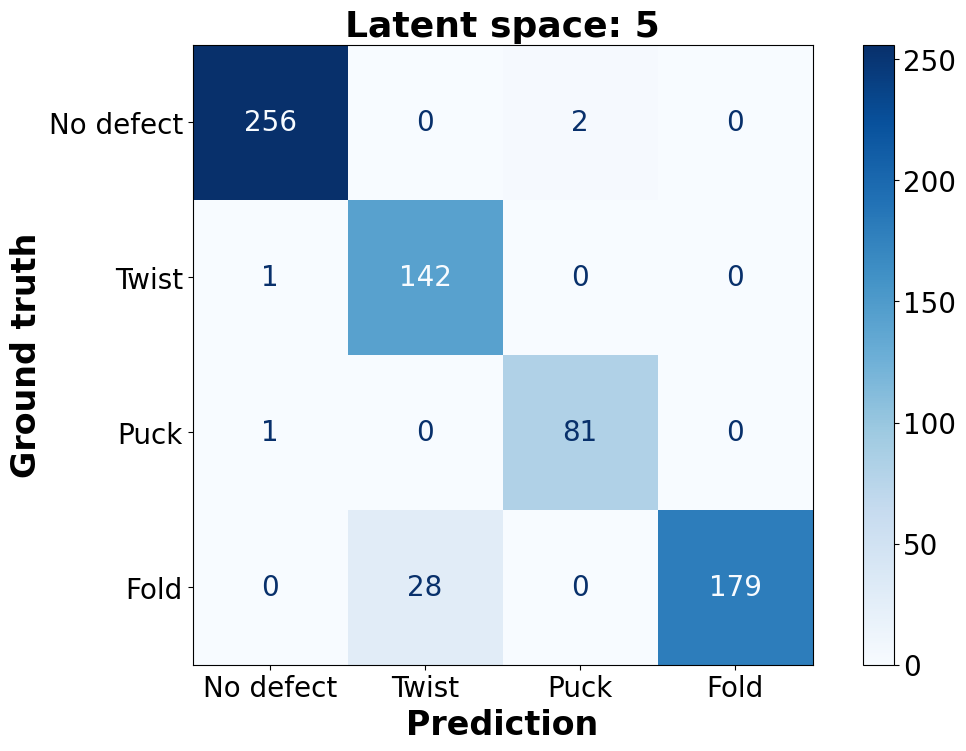

In [33]:
average = 'macro'

cm = get_confusion_matrix(y_gt_array, y_pred_array)
#get precision, recall, F1-score via sklearn
precision = precision_score(y_gt_array, y_pred_array, average=average)
recall = recall_score(y_gt_array, y_pred_array, average=average)
f1 = f1_score(y_gt_array, y_pred_array, average=average)
print(f'LS:{unit_numb}. Accuracy {get_accuracy(cm)}')
print(f'LS:{unit_numb}. Precision: {precision}')
print(f'LS:{unit_numb}. Recall: {recall}')
print(f'LS:{unit_numb}. F1_score: {f1}')
cm_plot_options = {'plot_title':f'Latent space: {unit_numb}'}
cm_save_opt_dict = {
    'ifSave':False, 
    'path':'pictures/paper_pictures/stride_50/confusion', 
    'file_name':f'{unit_numb}_test.svg'
}
plot_confusion_matrix(cm, cm_plot_options, cm_save_opt_dict)

In [30]:
#get confusion matrix for prediction
#stride 50, frames_to_pred_total = 68
#stride 100, frames_to_pred_total = 34

#load models
stride_step = 50
unit_numb = 30

window_size = 6
window_size_predicted = 1
overlap = 0
lstm_type = 'win'
stateful = False
#how many frames to predict within a single step
repeat_prediction = 6
#how many steps
frames_to_pred_total = 69
verbose = 0
print(f'Stride: {stride_step}; predict: {window_size, window_size_predicted, overlap}; repeat_prediction: {repeat_prediction}; stateful: {stateful}')

image_list = [
    'Pucker26.png',
    'Twist22.png',
    'Twist23.png',
    'Fold22.png',
    'Pucker13.png',
    'Pucker3.png',
    'Twist10.png',
    'Pucker31.png',
    'Fold21.png',
    'Fold9.png',
]

padding_dict = {
    'ifPadding':True,
    'max_window_size':12,        
}

lstm_pars_dict = {
    'stateful':stateful,
    'window_size':window_size,
    'window_size_predicted':window_size_predicted,
    'overlap':overlap,
    'lstm_type':lstm_type,
}

#load labels
file_name = f'defects_borders.json'
folder = f'save_data/classify_data' 
with open(f'{folder}/{file_name}', 'r') as f:
    borders_dict = json.load(f)

models_dict = load_models(unit_numb, stride_step, lstm_pars_dict, classifier=True, ifProbability=False)

y_pred_array = np.array([])
y_gt_array = np.array([])

window_size_total = window_size + (window_size_predicted-overlap)*repeat_prediction

for filename in image_list:
    print(filename)
    image_data_gt = load_image(filename)
    image_data_frames_gt = get_frames(image_data_gt, stride_step, ifPrint = False)
    
    borders_list = borders_dict[filename]
    image_length = image_data_gt.shape[1]
    defect_type = get_defect_label(filename)
    predicted_data_dict = {}
    labels_dict = {}
    
    labels_gt = get_labels(
        stride_step,
        borders_list, 
        image_length, 
        #window_size_total//2, 
        window_size_total,
        defect_type
    )[:frames_to_pred_total]
    labels_dict['gt'] = labels_gt
    
    image_data_frames_list, image_data_frames_encoded = predict_image(
        image_data_frames_gt, 
        models_dict,
        lstm_pars_dict, 
        repeat_prediction,
        verbose=verbose,
        frames_to_pred_total=frames_to_pred_total
    )
    predicted_data_dict[unit_numb] = image_data_frames_list
    
    #classify
    #probabilities of defects for each frame
    try:
        probabilities = models_dict['model_classifier'].predict(np.array(image_data_frames_encoded), verbose=0)
        labels_predicted = np.argmax(probabilities, axis=1)
        labels_dict[unit_numb] = [labels_predicted, probabilities]
        
        y_pred_array = np.append(y_pred_array, labels_predicted)
        y_gt_array = np.append(y_gt_array, labels_gt)
    except KeyError:
        #if no classifier is available
        pass    

Stride: 50; predict: (6, 1, 0); repeat_prediction: 6; stateful: False
Pucker26.png
Twist22.png
Twist23.png
Fold22.png
Pucker13.png
Pucker3.png
Twist10.png
Pucker31.png
Fold21.png
Fold9.png


LS:30. Accuracy 0.9405797101449276
LS:30. Precision: 0.9464740783392387
LS:30. Recall: 0.8947606326364126
LS:30. F1_score: 0.9106057752667922


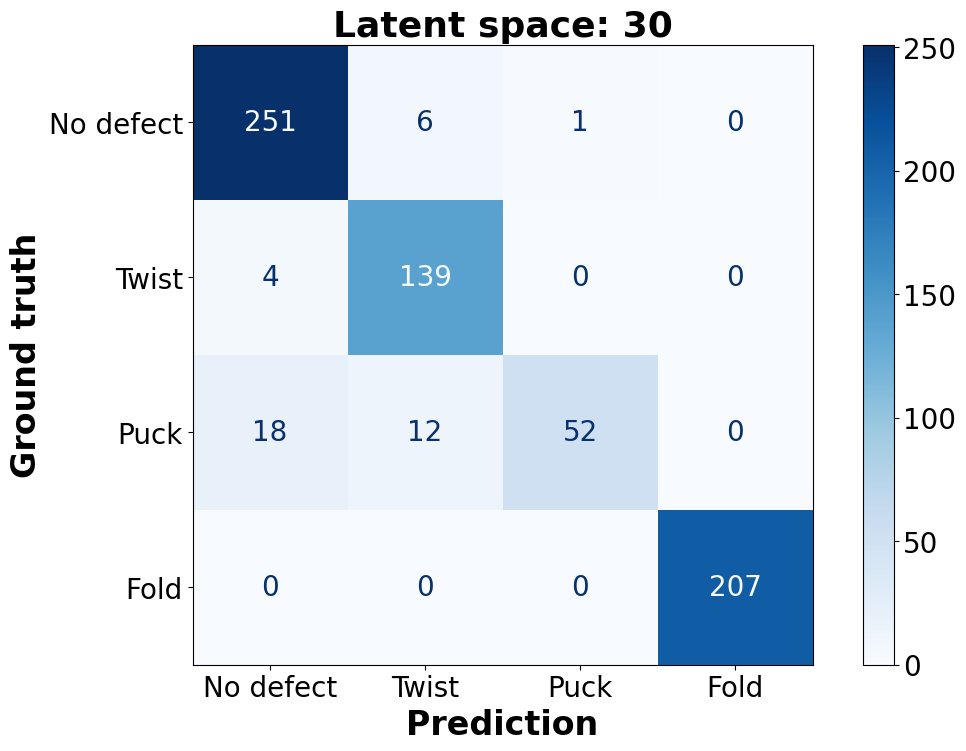

In [31]:
average='macro'
cm = get_confusion_matrix(y_gt_array, y_pred_array)
#get precision, recall, F1-score via sklearn
precision = precision_score(y_gt_array, y_pred_array, average=average)
recall = recall_score(y_gt_array, y_pred_array, average=average)
f1 = f1_score(y_gt_array, y_pred_array, average=average)
print(f'LS:{unit_numb}. Accuracy {get_accuracy(cm)}')
print(f'LS:{unit_numb}. Precision: {precision}')
print(f'LS:{unit_numb}. Recall: {recall}')
print(f'LS:{unit_numb}. F1_score: {f1}')
cm_plot_options = {'plot_title':f'Latent space: {unit_numb}'}
cm_save_opt_dict = {
    'ifSave':False, 
    'path':'pictures/paper_pictures/stride_50/confusion', 
    'file_name':f'pred_{unit_numb}_test.svg'
}
plot_confusion_matrix(cm, cm_plot_options, cm_save_opt_dict)